In [1]:
from calciumflexanalysis import calcium_flex as cal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
wells = {6:(2, 3), 12:(3, 4), 24:(4, 6), 48:(6, 8), 96:(8, 12), 384:(16, 24)}
size = 96

In [3]:
# text file to be read in (raw file from machine)
datafile = '291019 TPC4sYFP2 EA 30 nM act IBP74 inhib 3 nM to 3 uM.txt' 

# plate map csv file updated by user (either the 'short' or 'long' template)
mapcsv = 'EA 30 nM act IBP74 3nM to 3 uM.csv' 

# insert the 2 files into the 'CaFlexAnalysis' class
flex = cal.CaFlexAnalysis(raw_data = datafile, plate_map_file = mapcsv, data_type = 'new')

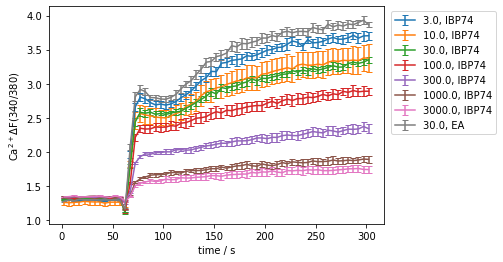

In [4]:
platemap = flex.plate_map
grouplist = ['Protein','Type', 'Compound','Concentration']

groupdct = {}
for key, val in flex.processed_data['ratio'].items():
    mapped = platemap.join(val)
    group = mapped[mapped.Valid == True].groupby(grouplist)[val.columns]
    # update dictionary
    groupdct[key] = group
    
# plot series for each condition and control
for i in range(len(groupdct['time'].mean())):
    plt.errorbar(groupdct['time'].mean().iloc[i], groupdct['data'].mean().iloc[i], yerr=groupdct['data'].sem().iloc[i], 
                 capsize = 3, 
                 label = "{}, {}".format(list(groupdct['data'].mean().index.get_level_values('Concentration'))[i], 
                                        list(groupdct['data'].mean().index.get_level_values('Compound'))[i])) 
    # add label function that concatenates conc w/ the correct units 
    plt.legend(loc = "upper right", bbox_to_anchor = (1.35, 1.0))
    plt.xlabel("time / s")
    plt.ylabel("$\mathrm{Ca^{2+} \Delta F(340/380)}$")
plt.show()

In [5]:
inject = 55
    
# change to do this for mean time for all columns
basal_tpoints = len(flex.processed_data['ratio']['time'].mean()[flex.processed_data['ratio']['time'].mean() < inject])
cal_basal = flex.processed_data['ratio']['data'].iloc[0, :basal_tpoints+1].mean()
amp = {'min':250, 'max':300+10}

# this finds the index values for the data between the stipulated amp times
amp_index_list =  list(flex.processed_data['ratio']['time'].loc["A1"][(flex.processed_data['ratio']['time'].loc["A1"] < amp['max']) 
                                              & (flex.processed_data['ratio']['time'].loc["A1"] > amp['min'])].index)

amp_data = flex.processed_data['ratio']['data'].loc["A1", amp_index_list[0]:amp_index_list[-1]+1]
print(amp_data)
amp_mean = amp_data.mean()
print(amp_mean)
amp_response = amp_mean - cal_basal
print(amp_response)
flex.processed_data['ratio']['time'].iloc[0].name

50    4.007072
51    3.916804
52    3.964455
53    3.966316
54    4.040859
55    4.022209
56    4.065501
57    4.049009
58    4.000950
59    4.061678
60    4.009494
Name: A1, dtype: float64
4.009486143576546
2.7127463103882974


'A1'

In [6]:
inject = 55
amp = {'min':250, 'max':300}

# initiate dict 
amp_response_dict = {}

# index of data points within basal range (0 to 'inject')
basal_tpoints = len(flex.processed_data['ratio']['time'].mean()[flex.processed_data['ratio']['time'].mean() < inject])

# FOR ALL WELLS: 
for i in range(size):
    cal_basal = flex.processed_data['ratio']['data'].iloc[i, :basal_tpoints+1].mean()
    amp_index_list =  list(flex.processed_data['ratio']['time'].iloc[i][(flex.processed_data['ratio']['time'].iloc[i] < amp['max']) 
                                              & (flex.processed_data['ratio']['time'].iloc[i] > amp['min'])].index)
    if len(amp_index_list) != 0: # removes error caused by empty rows
        amp_data = flex.processed_data['ratio']['data'].iloc[i].loc[amp_index_list[0]:amp_index_list[-1]+1]
        amp_response_dict[flex.processed_data['ratio']['data'].iloc[i].name] = amp_data.mean() - cal_basal



In [7]:
# update platemap with response amplitude
resp_platemap = flex.plate_map
resp_platemap['Response Amplitude'] = resp_platemap['Well ID'].map(amp_response_dict)
resp_platemap

,Well ID,Type,Contents,Compound,Protein,Concentration,Concentration Units,Row,Column,Valid,Response Amplitude
Well ID,,,,,,,,,,,
A1,A1,control,EA+DMSO,EA,TRPC5,30.0,nM,A,1,True,2.712746
A2,A2,control,EA+DMSO,EA,TRPC5,30.0,nM,A,2,True,2.611655
A3,A3,control,EA+DMSO,EA,TRPC5,30.0,nM,A,3,True,2.364593
A4,A4,control,EA+DMSO,EA,TRPC5,30.0,nM,A,4,True,2.471823
A5,A5,control,EA+DMSO,EA,TRPC5,30.0,nM,A,5,True,2.561901
...,...,...,...,...,...,...,...,...,...,...,...
H8,H8,empty,NaN,NaN,NaN,NaN,NaN,H,8,True,NaN
H9,H9,empty,NaN,NaN,NaN,NaN,NaN,H,9,True,NaN
H10,H10,empty,NaN,NaN,NaN,NaN,NaN,H,10,True,NaN


In [8]:
# mean response amplitude for each condition
group = resp_platemap[resp_platemap.Valid == True] 
group.drop(['Valid', 'Column'], axis = 1, inplace = True)
mean_response_amp = group.groupby(grouplist).mean()
mean_response_amp

Response Amplitude
Protein Type     Compound Concentration                    
TRPC5   compound IBP74    3.0                      2.369590
                          10.0                     2.069404
                          30.0                     1.957433
                          100.0                    1.533918
                          300.0                    0.985038
                          1000.0                   0.533334
                          3000.0                   0.396540
        control  EA       30.0                     2.562130

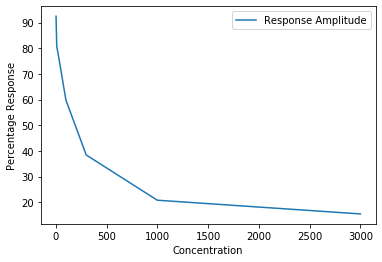

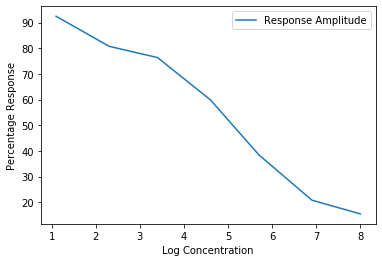

In [17]:
# percentage response

# some crazy slicing to get the control amplitude
control_amp = float(mean_response_amp[mean_response_amp.index.isin(['control'], level = 'Type')]['Response Amplitude'])
perc_response = (mean_response_amp   / control_amp)*100
perc_response.reset_index(inplace = True)
perc_response = perc_response[perc_response['Type'] != "control"] # remove 'control amplitude (=1) '
perc_response['Log Concentration'] = np.log(perc_response['Concentration'])
ax1 = perc_response.plot(x = 'Concentration', y = 'Response Amplitude')
ax2 = perc_response.plot(x = 'Log Concentration', y = 'Response Amplitude')
ax1.set_ylabel('Percentage Response')
ax2.set_ylabel('Percentage Response')

plt.show()